# Perera Multitask Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summit import *
from multitask import *


from botorch.models import MultiTaskGP, SingleTaskGP, MixedSingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import (
    ExactMarginalLogLikelihood,
)

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import torch

import ord_schema
from ord_schema import message_helpers
from ord_schema.proto.dataset_pb2 import *

from rdkit import Chem

import matplotlib.pyplot as plt
from fastprogress import progress_bar
from pathlib import Path
from typing import Iterable
import pandas as pd
import numpy as np
from numpy.random import default_rng
from copy import deepcopy

## Load Data

In [3]:
data_path = Path("../data")
perera_suzuki_path = data_path / "perera_suzuki" / "ord"

In [4]:
# Load datasets
perera_datasets = [
    message_helpers.load_message(
        str(path), 
        dataset_pb2.Dataset
    )
    for path in perera_suzuki_path.glob("*.pb")
]

In [5]:
def change_pd_acetate_representation(dataset: Dataset, copy=True):
    if copy:
        dataset = deepcopy(dataset)
    for reaction in dataset.reactions:
        inputs = reaction.inputs
        for inp in inputs:
            components = inputs[inp].components
            for c in components:
                if c is not None:
                    if c.reaction_role == ReactionRole.CATALYST:
                        for id_ in c.identifiers:
                            if id_.type == CompoundIdentifier.SMILES:
                                if "CC(=O)[O-].CC(=O)[O-].[Pd+2]" in id_.value:
                                     id_.value = "CC(=O)O[Pd]OC(=O)C"
    return dataset

In [6]:
# Correct Pd acetate representation
perera_datasets = [
    change_pd_acetate_representation(dataset)
    for dataset in perera_datasets
]

## Create pandas dataframes

In [7]:
perera_df_list = [
    suzuki_reaction_to_dataframe(
        dataset.reactions
    )
    for dataset in perera_datasets
]

In [8]:
approved_ligands = [
    'CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1',
    'COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1',
    'c1ccc(P(c2ccccc2)c2ccccc2)cc1', 'CC(C)(C)P(C(C)(C)C)C(C)(C)C',
    'CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3ccccc3)c3ccccc3)cccc21',
    'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1',
    'CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1'
]

In [9]:
perera_df_list = [
    df[df["ligand_smiles"].isin(approved_ligands)]
    for df in perera_df_list
]

In [10]:
perera_df_list = [
    df.fillna("")
    for df in perera_df_list
]

In [11]:
df = perera_df_list[0]
ligands = df["ligand_smiles"].unique()
print(f"Number of unique ligands in DataSet: {len(ligands)}")
count = 0
for ligand in ligands:
    if ligand in approved_ligands:
        count += 1
print(f"Matching approved ligands: {count}")

Number of unique ligands in DataSet: 6
Matching approved ligands: 6


In [13]:
df["ligand_smiles"].value_counts()

c1ccc(P(c2ccccc2)c2ccccc2)cc1                                         32
CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1             32
CC(C)(C)P(C(C)(C)C)C(C)(C)C                                           32
COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1                            32
CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c(P(c3ccccc3)c3ccccc3)cccc21    32
C1CCC(P(C2CCCCC2)C2CCCCC2)CC1                                         32
Name: ligand_smiles, dtype: int64

## Train Single Models

In [12]:
# Transform inputs
def get_ct():
    continuous_features = [
        "catalyst_loading",
        "ligand_ratio",
        "temperature",
        "time"
    ]
    categorical_features = [
        "base_smiles",
        "ligand_smiles",
        "solvent",
    ]
    transformers = []
    transformers.append(
        (
            "continuous",
            StandardScaler(),
            continuous_features
        )
    )
    transformers.append(
        (
            "ordinal",
            OrdinalEncoder(),
            categorical_features
        )
    )
    return ColumnTransformer(transformers)

In [32]:
def train_single_task_model(df, include_continuous=True):
    continuous_features = [
        "catalyst_loading",
        "ligand_ratio",
        "temperature",
        "time"
    ]
    categorical_features = [
        "base_smiles",
        "ligand_smiles",
        "solvent",
    ]
    features = categorical_features
    if include_continuous:
        features += continuous_features
    features.append("yld")
    df = df.copy()[features]

    if include_continuous:
        input_transform = get_ct()
    else:   
        input_transform = OrdinalEncoder()
        
    train_X = input_transform.fit_transform(df)
    output_scaler = StandardScaler()
    train_y = output_scaler.fit_transform(df[["yld"]])

    model = MixedSingleTaskGP(
        train_X=torch.tensor(train_X),
        train_Y=torch.tensor(train_y),
        cat_dims=[0,1,2]
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    
    return {
        "input_transform": input_transform,
        "output_transform": output_scaler,
        "train_X": train_X,
        "train_y": train_y,
        "model": model
    }

In [34]:
# Categorical only
results_categorical_only = [
    train_single_task_model(df, include_continuous=False)
    for df in progress_bar(perera_df_list)
]

In [95]:
# Categorical only
results_categorical_continuous = [
    train_single_task_model(df, include_continuous=True)
    for df in progress_bar(perera_df_list)
]

In [16]:
def parity_plot(result: dict, ax: plt.Axes = None):
    # Train resultss
    model = result["model"]
    train_posterior = model.posterior(torch.tensor(result["train_X"]))
    train_y_pred_mean = train_posterior.mean.detach()
    train_y_pred_std = train_posterior.variance.sqrt()
    train_y_pred_mean = result["output_transform"].inverse_transform(train_y_pred_mean)
    train_y = result["output_transform"].inverse_transform(result["train_y"])
    

    # Plotting
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.plot([0,100], [0,100], "--")
    ax.scatter(train_y, train_y_pred_mean)
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)

Text(0.5, 0.98, 'Categorical only')

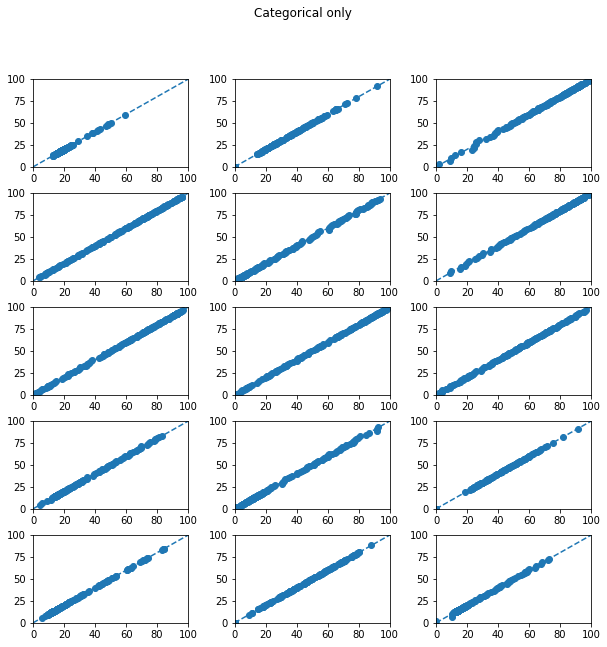

In [35]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, result in enumerate(results_categorical_only):
    ax = fig.add_subplot(5,3, i+1)
    parity_plot(result, ax)
fig.suptitle("Categorical only")

Text(0.5, 0.98, 'Categorical + Continuous')

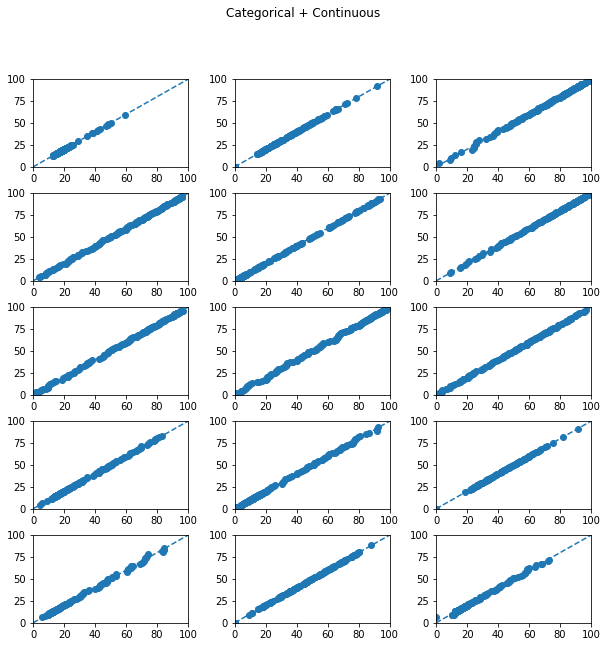

In [97]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, result in enumerate(results_categorical_continuous):
    ax = fig.add_subplot(5,3, i+1)
    parity_plot(result, ax)
fig.suptitle("Categorical + Continuous")

## Train Multitask Model

In [ ]:
# Parameters
df = perera_df_list[0]
include_continuous=True

# Choose ligand to hold out
rng = default_rng(10)
ligands = df["ligand_smiles"].unique()
hold_out_ligand = rng.choice(ligands)

# Create train and test dataframes
train_df = df[df["ligand_smiles"] != hold_out_ligand]
test_df = df[df["ligand_smiles"] == hold_out_ligand]

# Create multitask train df
train_df = train_df.copy()
train_df["task"] = 0
for i, co_train_df  in enumerate(perera_df_list[1:]):
    co_train_df = co_train_df.copy()
    co_train_df["task"] = i+1
    train_df = pd.concat([train_df, co_train_df])

# Preprocessing
categorical_features = [
    "ligand_smiles",
    "base_smiles",
    "solvent",
]
continuous_features = [
    "catalyst_loading",
    "ligand_ratio",
    "temperature",
    "time"
]

features = deepcopy(categorical_features)
if include_continuous:
    features += continuous_features
features.extend(["yld", "task"])
train_df = train_df.copy()[features]

if include_continuous:
    input_transform = get_ct()
else:   
    input_transform = OrdinalEncoder()
    
train_X = input_transform.fit_transform(train_df[categorical_features+continuous_features])
train_X = np.append(train_X, train_df[["task"]], axis=1).astype(
    np.float
)
output_scaler = StandardScaler()
train_y = output_scaler.fit_transform(train_df[["yld"]])


# Train model
model = MixedMultiTaskGP(
    train_X=torch.tensor(train_X),
    train_Y=torch.tensor(train_y),
    task_feature=-1,
    cat_dims=[0,1,2],
    output_tasks=[0]
)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(0.0, 100.0)

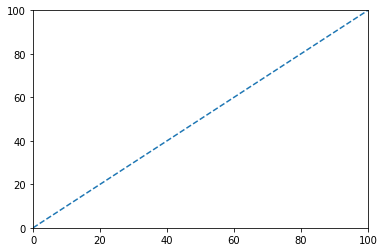

In [20]:
result = {
    "input_transform": input_transform,
    "output_transform": output_scaler,
    "train_X": train_X[:160, :-1],
    "train_y": train_y[:160],
    "model": model
}
model = result["model"]
train_posterior = model.posterior(torch.tensor(result["train_X"]))
train_y_pred_mean = train_posterior.mean.detach()
train_y_pred_std = train_posterior.variance.sqrt()
train_y_pred_mean = result["output_transform"].inverse_transform(train_y_pred_mean)
train_y = result["output_transform"].inverse_transform(result["train_y"])


# Plotting

fig, ax = plt.subplots(1)
ax.plot([0,100], [0,100], "--")
ax.scatter(train_y, train_y_pred_mean)
ax.set_xlim(0,100)
ax.set_ylim(0,100)

In [18]:
train_X.shape

(2848, 8)

In [67]:
input_transform.fit_transform(train_df[categorical_features])

array([[1., 0., 6.],
       [5., 0., 6.],
       [0., 0., 6.],
       ...,
       [4., 4., 4.],
       [2., 4., 4.],
       [3., 4., 4.]])

In [63]:
input_transform.fit(train_df[categorical_features])
test_X = input_transform.transform(test_df[categorical_features])
output_scaler = StandardScaler()
output_scaler.fit(train_df[["yld"]])
test_y = output_scaler.transform(test_df[["yld"]])

result = {
    "input_transform": input_transform,
    "output_transform": output_scaler,
    "train_X": test_X,
    "train_y": test_y,
    "model": model
}
parity_plot(result)

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Parameters
df = perera_df_list[0]
include_continuous=False

# Choose ligand to hold out
rng = default_rng(10)
ligands = df["ligand_smiles"].unique()
hold_out_ligand = rng.choice(ligands)

# Create train and test dataframes
train_df = df[df["ligand_smiles"] != hold_out_ligand]
test_df = df[df["ligand_smiles"] == hold_out_ligand]

# Create multitask train df
train_df = train_df.copy()
train_df["task"] = 0
for i, co_train_df  in enumerate(perera_df_list[1:]):
    co_train_df = co_train_df.copy()
    co_train_df["task"] = i+1
    train_df = pd.concat([train_df, co_train_df])

# Preprocessing
categorical_features = [
    "ligand_smiles",
    "base_smiles",
    "solvent",
]
continuous_features = [
    "catalyst_loading",
    "ligand_ratio",
    "temperature",
    "time"
]

features = deepcopy(categorical_features)
if include_continuous:
    features += continuous_features
features.extend(["yld", "task"])
train_df = train_df.copy()[features]

if include_continuous:
    input_transform = get_ct()
else:   
    input_transform = OrdinalEncoder()
    
train_X = input_transform.fit_transform(train_df[categorical_features])
output_scaler = StandardScaler()
train_y = output_scaler.fit_transform(train_df[["yld"]])


# Train model
model = MixedSingleTaskGP(
    train_X=torch.tensor(train_X),
    train_Y=torch.tensor(train_y),
    cat_dims=[0,1,2],
    output_tasks=[0]
)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)